In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

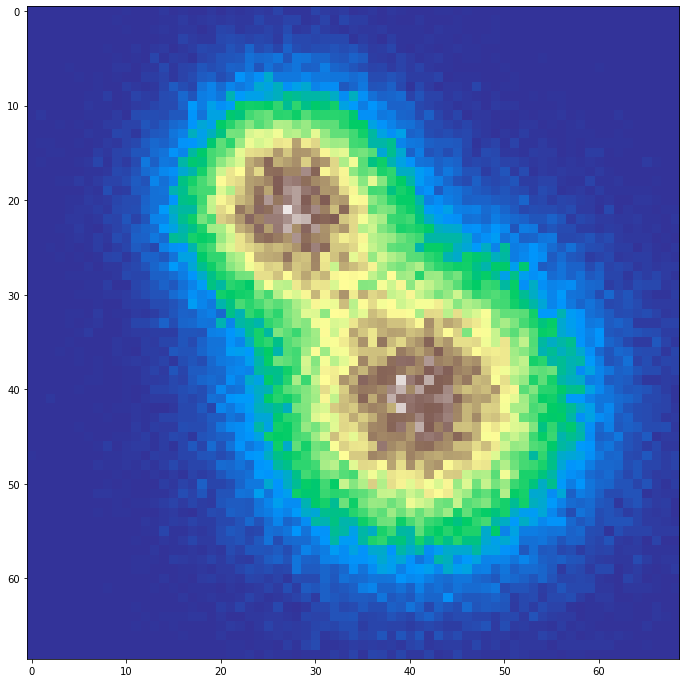

In [61]:
samples1 = np.random.multivariate_normal((6, 6), cov=np.eye(2)*2, size=100000)
samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2), size=50000)
samples = np.concatenate((samples1, samples2))
bins = np.linspace(0, 10, 70)
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0] - 10

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain, vmin=-10, vmax=200)

In [62]:
land

array([[-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.],
       ...,
       [-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.]])

In [65]:
land

array([[  1.,  18.,  18.,   1.,   0.],
       [  4.,  78.,  91.,  19.,   3.],
       [  1.,  32., 100.,  84.,  16.],
       [  0.,  15.,  82.,  83.,  15.],
       [  0.,   3.,  15.,  15.,   3.]])

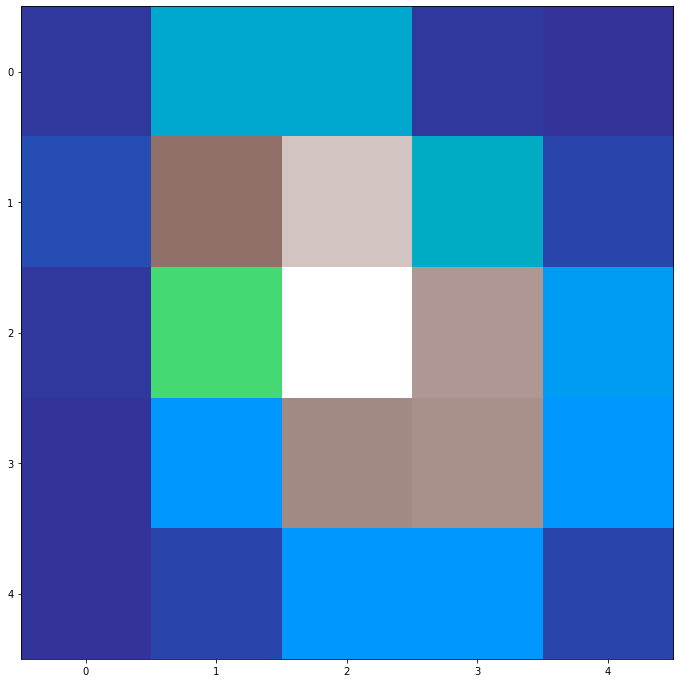

In [68]:
bins = np.linspace(0, 10, 6)
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0] - 10
land = np.round(land / land.max() * 100)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain, vmin=-0, vmax=100)

In [69]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

In [71]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [133]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        vmap += shifted_landslide.sum(axis=0)        
        return vmap
         
class RainFall(FlowRule):
    def __init__(self, net_rainfall=0.5, rainmap=None):
        """
        This is adds new rain water to the water canvas
        
        Perhaps later this will be a non uniform rainfall pattern, once heat and cold is introduced to 
        account for evaporation
        
        rainmap is the characteristic rainfall pattern
        net rainfall is the amplitude of the rainmap
        """
        self.layers = np.sort(("water",))
        self.key = "water"
               
        self.net_rainfall = net_rainfall
        self.rainmap = rainmap
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        if self.rainmap is not None:
            rainfall = self.rainmap * self.net_rainfall
        else:
            rainfall = np.ones(shape=water_local.shape) * self.net_rainfall
        water_local += rainfall
#         print(water_local)
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        

        
        
class Landslide(FlowRule):
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow = diffs * fractions * self.flow_factor # this is the outgoing amount
        
        height_local = self.calc_flows(cell, height_local, outflow)
        
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict
        
    
class WaterFlow(FlowRule):
    def __init__(self, water_flow_rate=0.5, land_coerosion_rate=0.1):
        """
        This is a two component erosion model where water flows fast, and drags a fraction of the land with it
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        """
        self.layers = np.sort(("water", "terrain"))
        self.wkey = "water"
        self.lkey = "terrain"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        

#         self.wmap_ocean = wmap_ocean
#         self.ii = wmap_ocean.astype(bool).flatten()

                
    def evolve(self, cell):
        np.set_printoptions(suppress=True)
        col = 15
        # these are the only canvases we are going to care about at all
        height_local = cell.canvases[self.lkey]
        height_shifted = cell.shifted_canvases[self.lkey]
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]

        diffs = (height_local + water_local) - (height_shifted + water_shifted)
        ii =  diffs < diffs.max(axis=0)
        diffs[ii] = 0. 
        
        wdiffs = diffs / (height_local + water_local) * water_local
        print(wdiffs)
        outflow_w =  wdif * self.water_flow_rate

        ldiffs = wdiffs / (height_local + water_local) * height_local
        outflow_l = self.land_coerosion_rate * ldiffs * (wdiffs / ldiffs)

        water_local = self.calc_flows(water_local, outflow_w, cell)
        height_local = self.calc_flows(height_local, outflow_l, cell)

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: height_local})
        
        np.set_printoptions(suppress=False)
        return resdict    
    
        


In [134]:
tmap = land - 10
wmap = land * 0 + 10
initial_maps = {
    "terrain": tmap,
    "water": wmap,
}
rules = (
    WaterFlow(land_coerosion_rate=0.1, water_flow_rate=0.4),
)


In [132]:
cs = CellSpace(initial_maps, rules)
cs.flow(100, savestep=1)

0 out of 99
[[[ 0.          0.          0.          0.                 nan]
  [ 7.5         0.          0.          0.          0.        ]
  [10.          0.          0.          0.          0.        ]
  [        nan  0.          8.17073171  8.19277108  8.        ]
  [        nan  0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.                 nan]
  [ 7.5         0.          8.02197802  9.47368421 10.        ]
  [ 0.          0.          0.          0.          8.125     ]
  [        nan  0.          0.          0.          0.        ]
  [        nan  0.          0.          0.          0.        ]]

 [[ 0.          0.          9.44444444 10.                 nan]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          8.0952381   0.        ]
  [        nan  0.          0.          8.19277108  0.        ]
  [        nan  0.          0.          8.          0.        ]]

 [[ 0.          9.4444

/tmp/ipykernel_4478/1426084427.py:132: RuntimeWarning: invalid value encountered in true_divide
  wdiffs = diffs / (height_local + water_local) * water_local


In [122]:
waters = np.array(cs.maps["water"])
terrain = np.array(cs.maps["terrain"])

/tmp/ipykernel_4478/1156021144.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


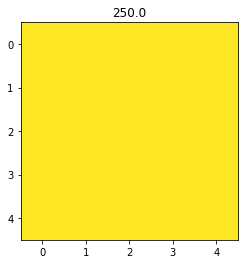

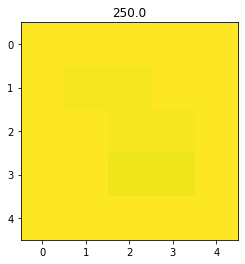

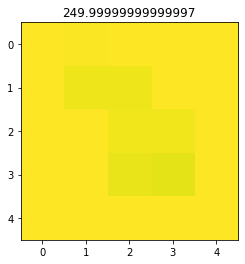

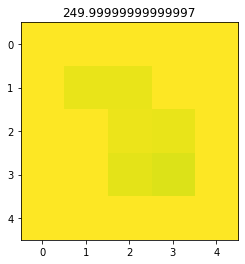

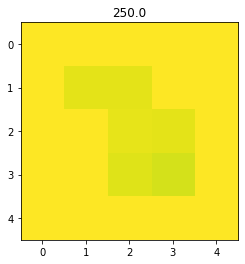

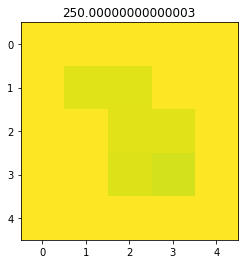

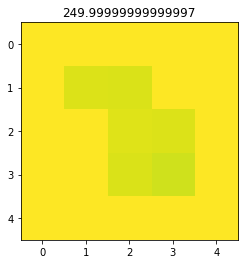

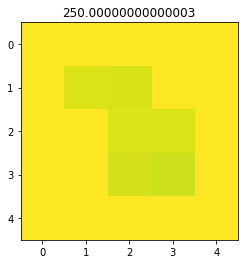

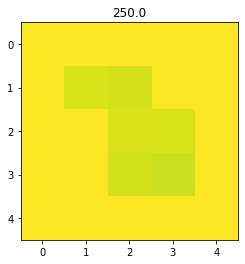

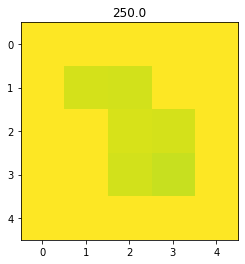

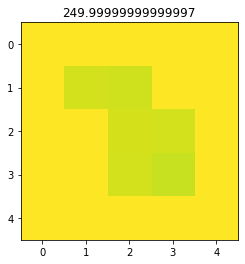

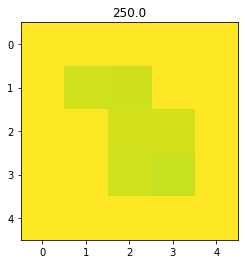

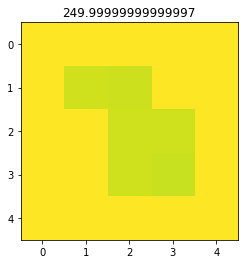

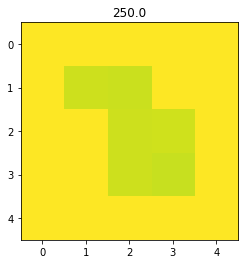

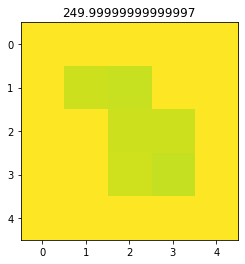

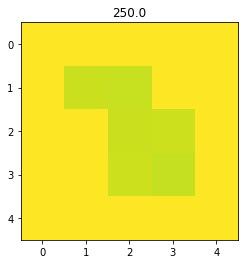

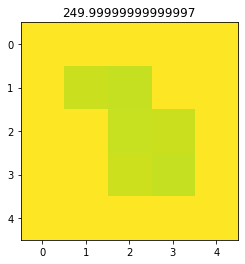

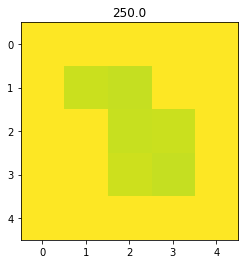

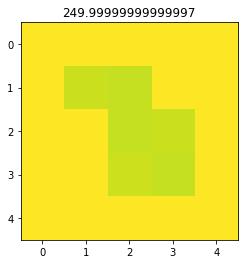

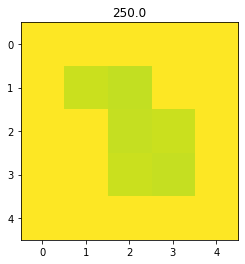

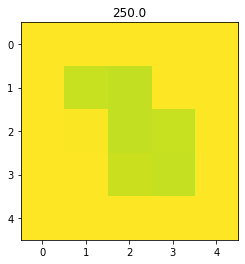

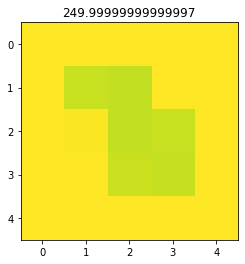

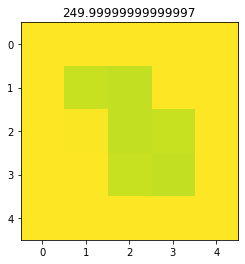

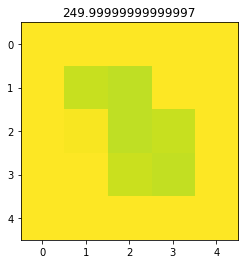

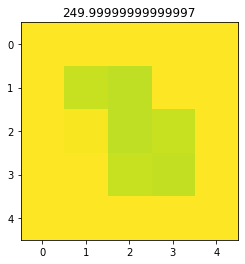

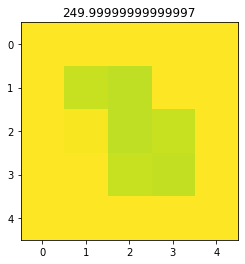

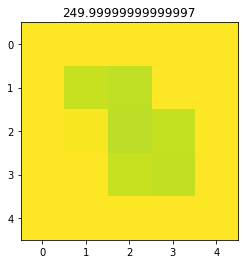

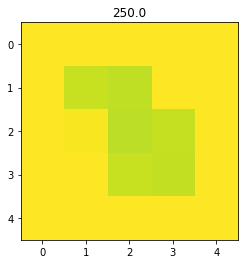

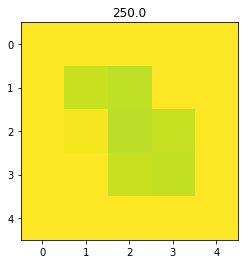

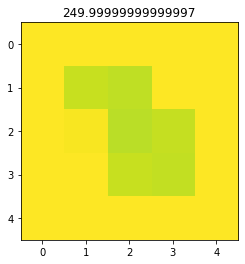

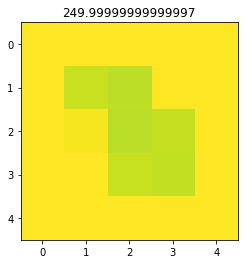

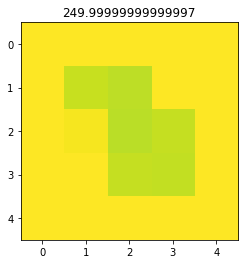

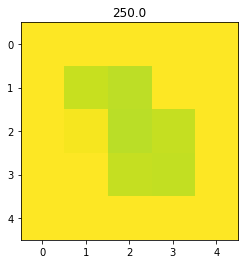

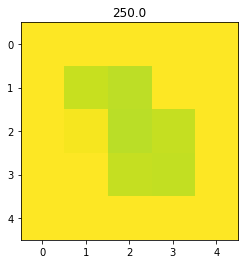

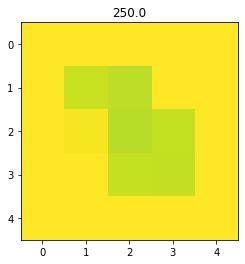

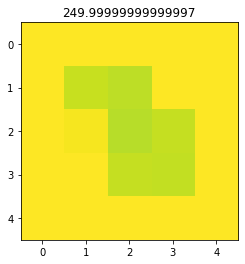

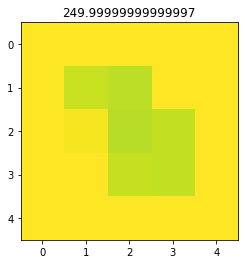

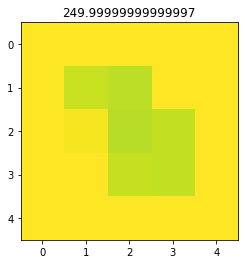

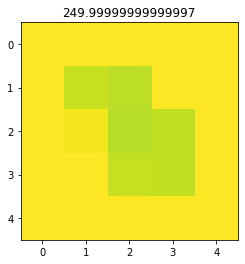

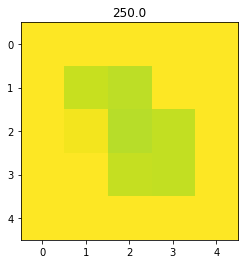

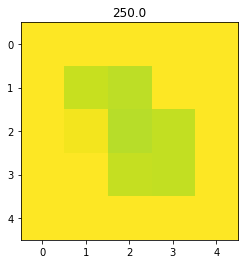

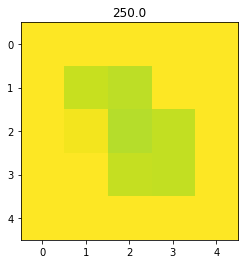

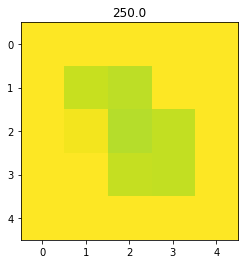

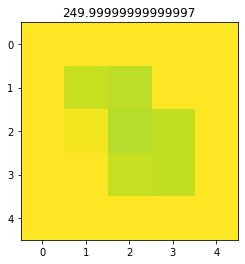

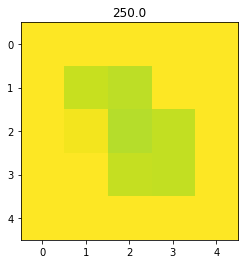

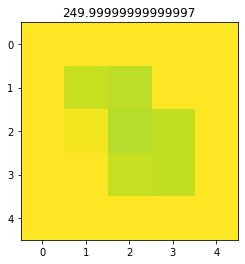

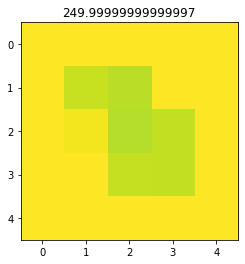

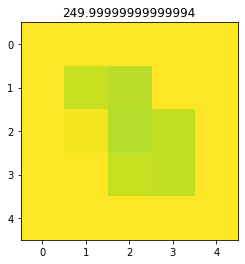

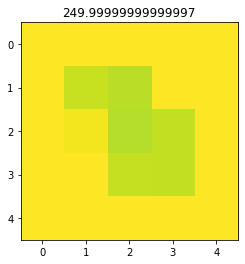

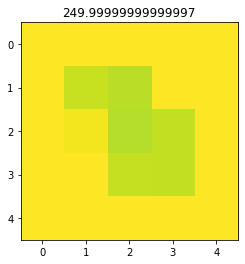

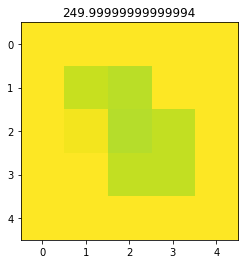

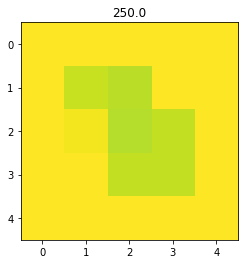

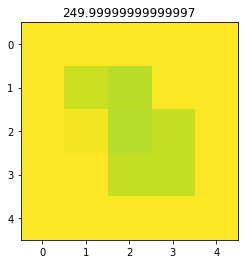

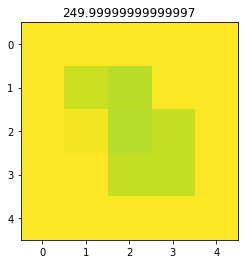

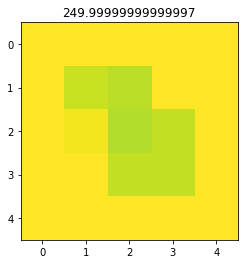

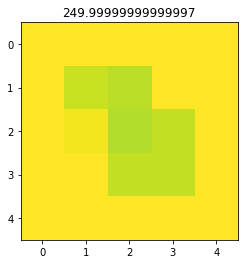

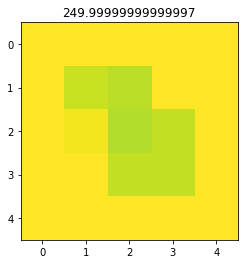

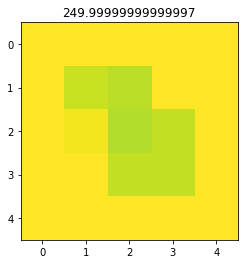

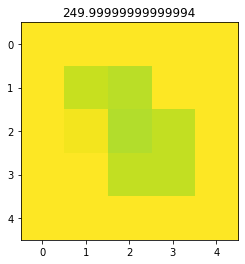

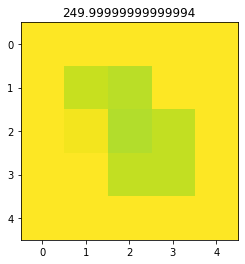

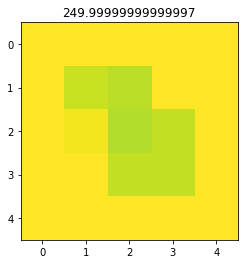

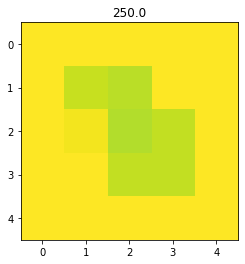

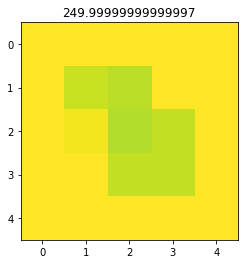

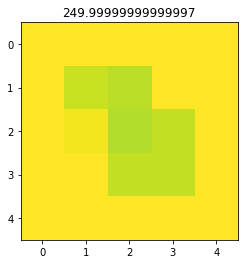

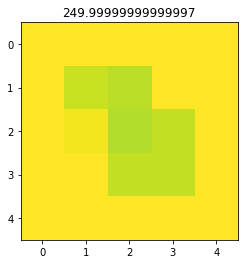

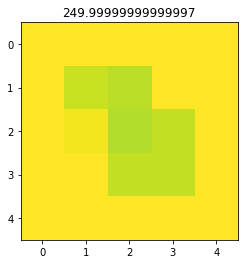

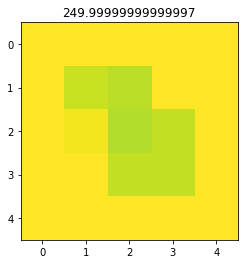

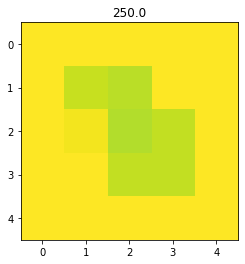

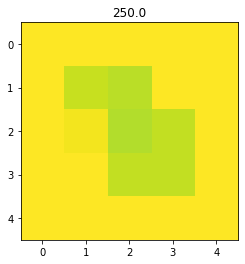

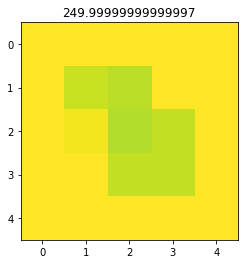

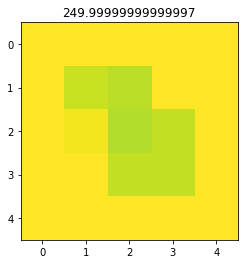

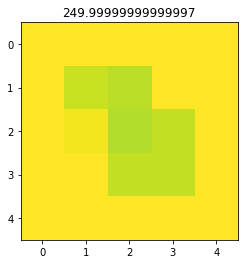

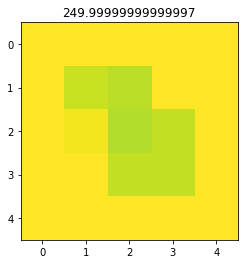

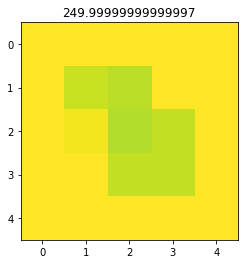

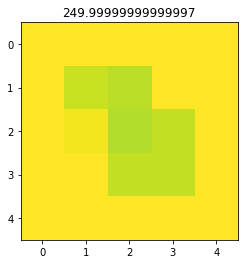

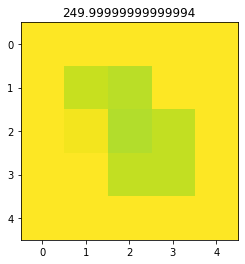

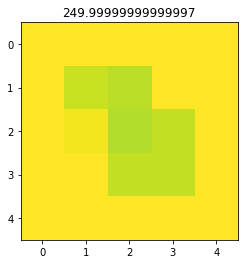

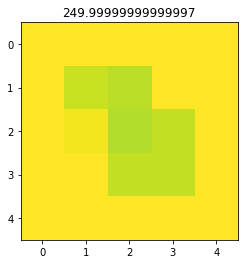

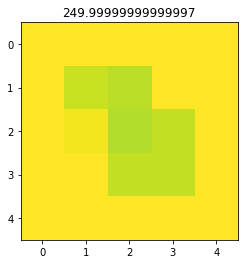

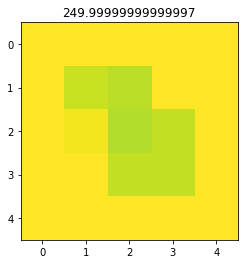

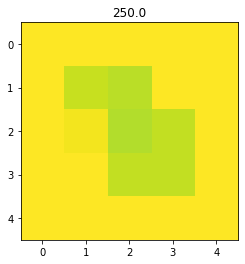

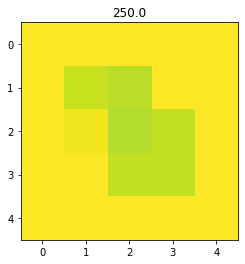

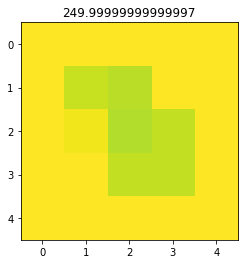

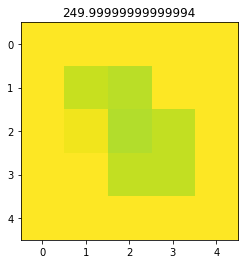

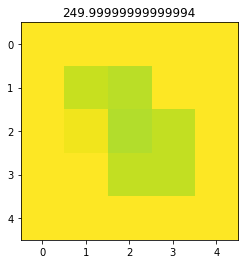

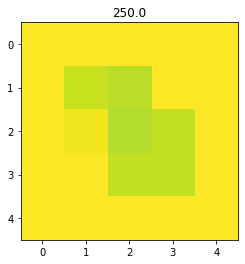

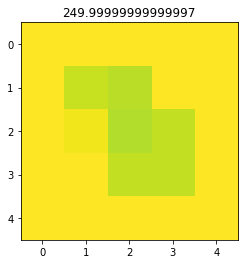

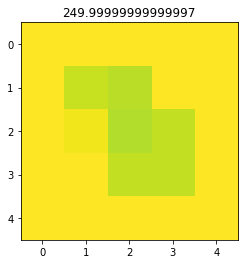

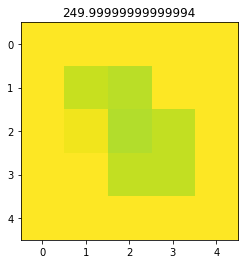

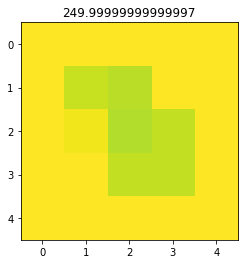

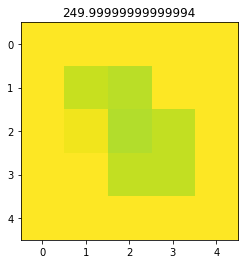

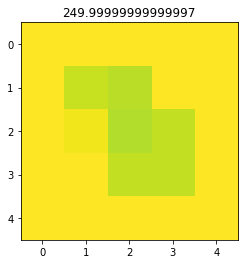

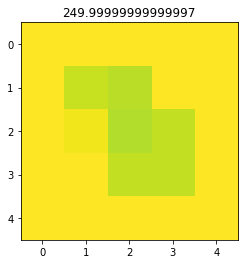

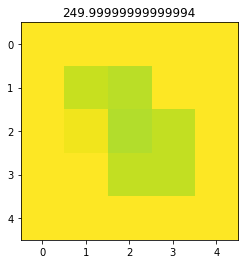

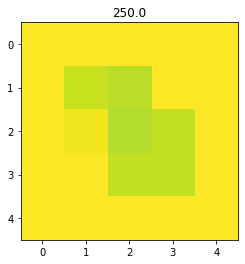

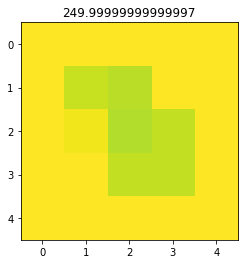

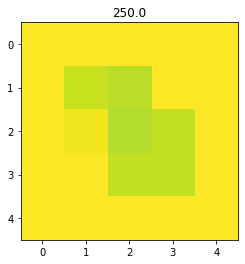

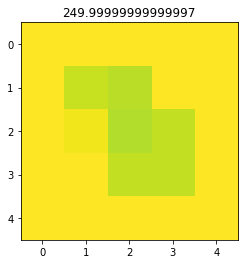

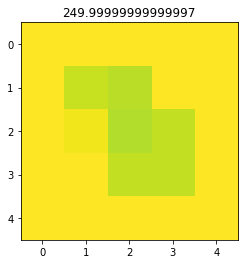

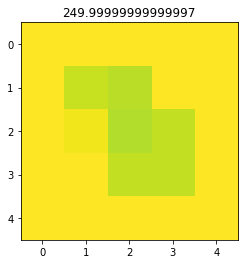

In [123]:
for i in np.arange(100):
    ww = waters[i]
    tt = terrain[i]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(ww, vmin=-10, vmax=10)
    ax.set_title(ww.sum())
#     plt.close(fig)

/tmp/ipykernel_4478/1029327473.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


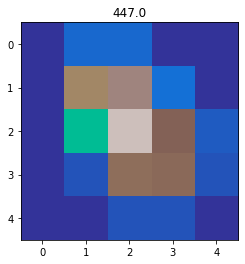

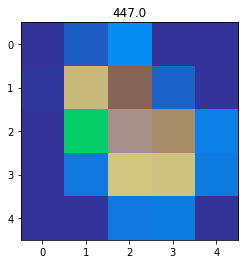

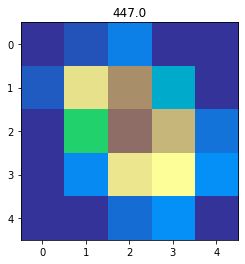

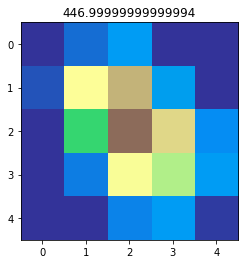

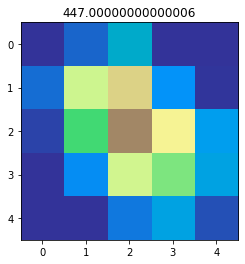

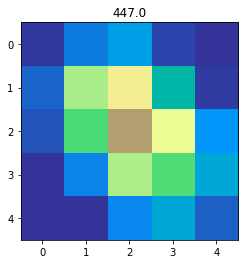

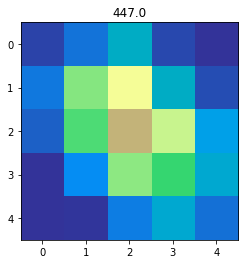

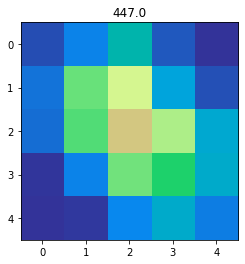

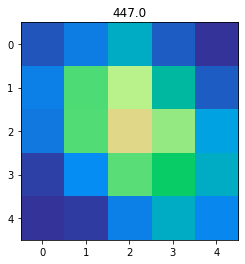

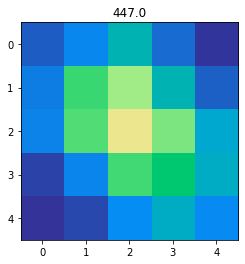

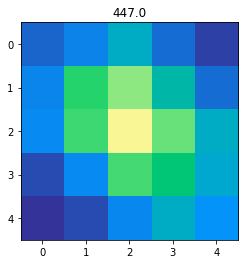

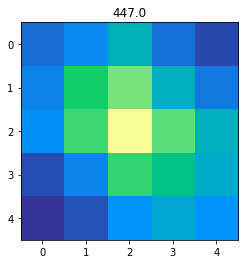

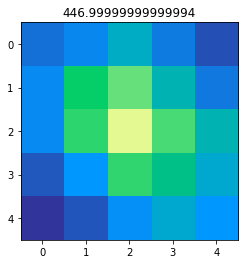

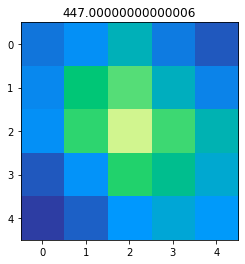

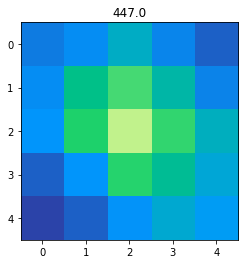

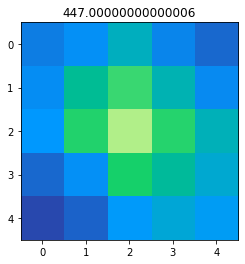

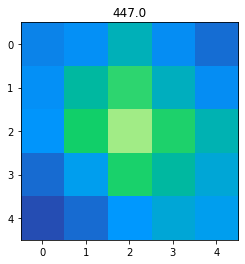

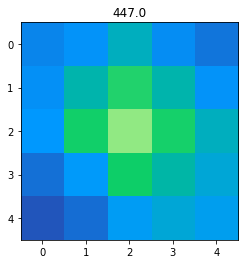

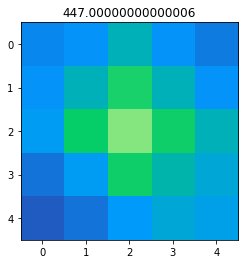

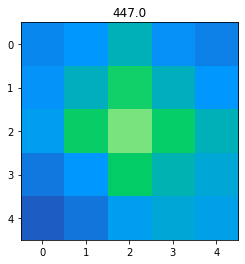

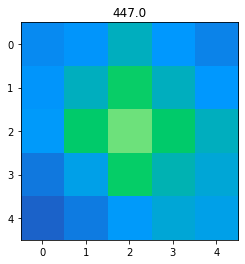

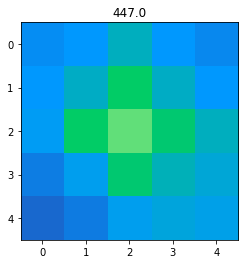

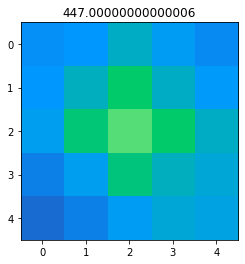

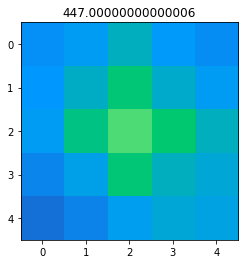

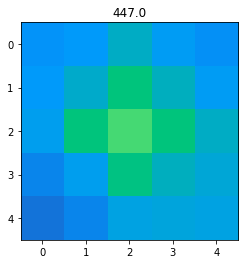

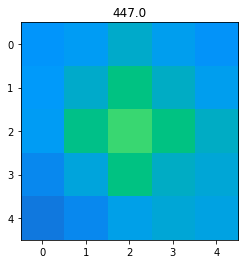

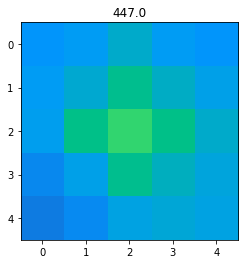

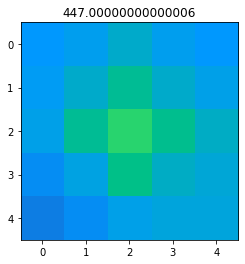

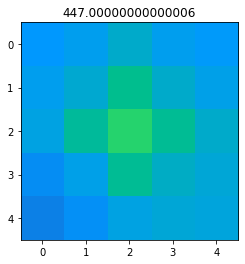

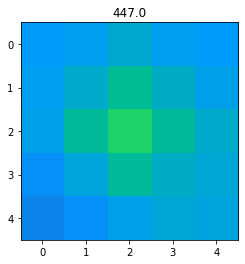

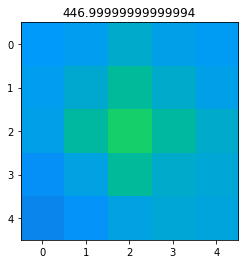

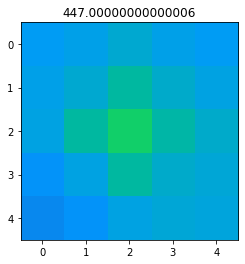

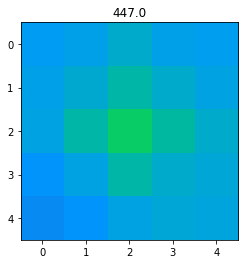

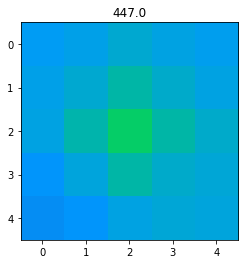

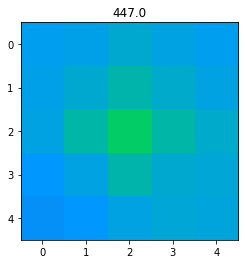

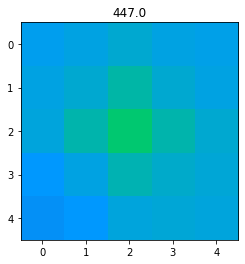

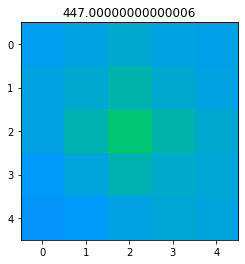

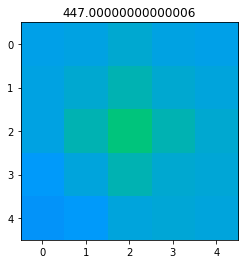

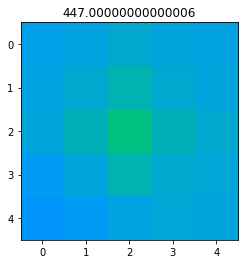

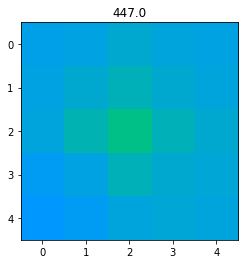

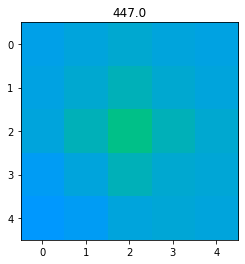

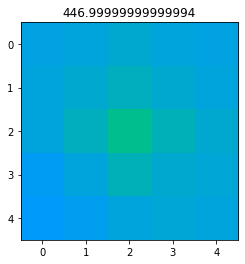

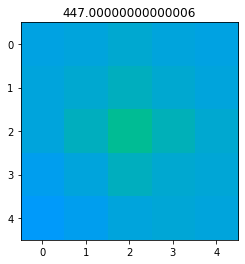

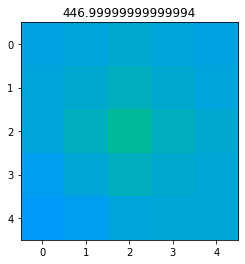

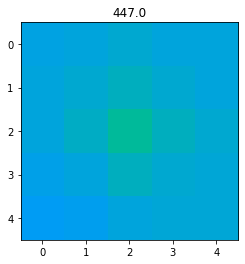

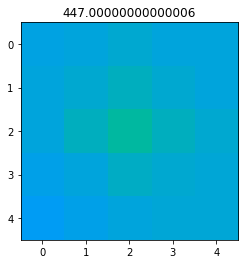

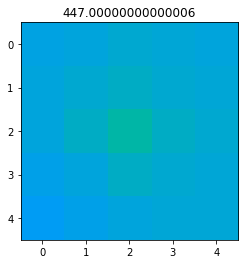

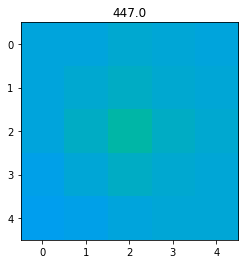

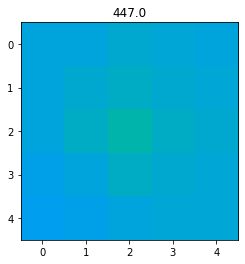

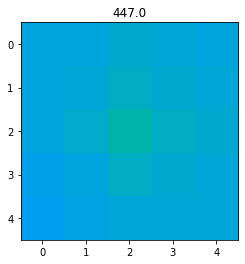

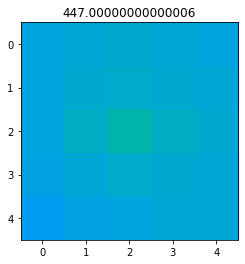

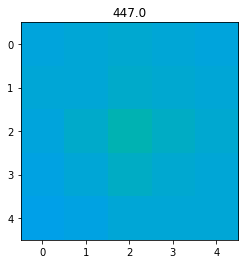

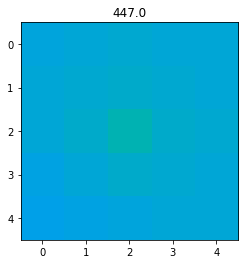

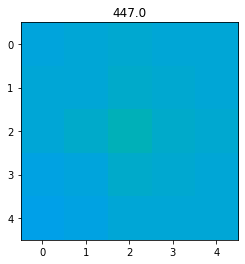

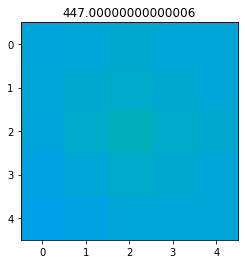

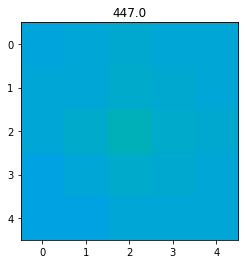

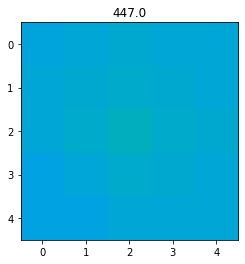

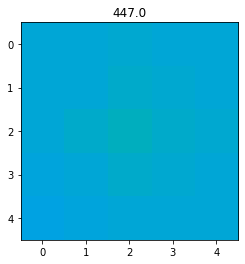

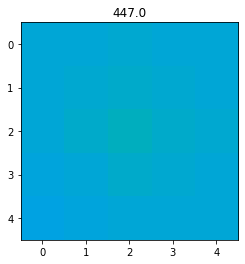

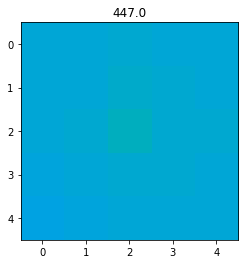

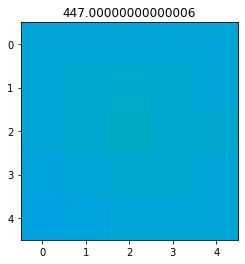

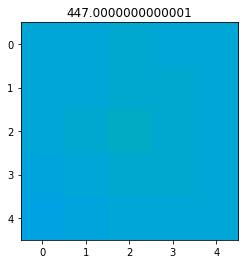

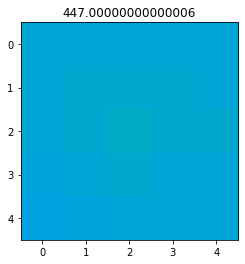

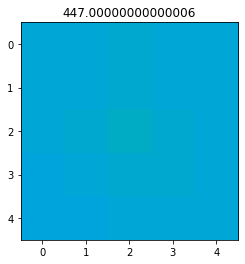

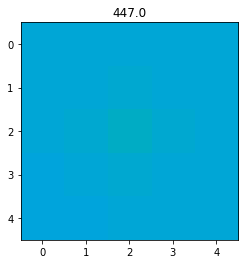

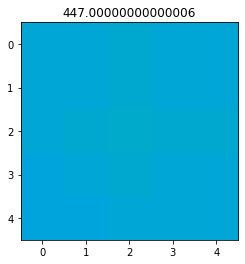

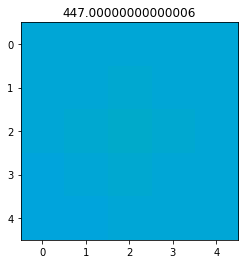

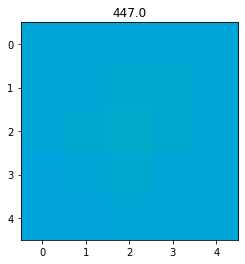

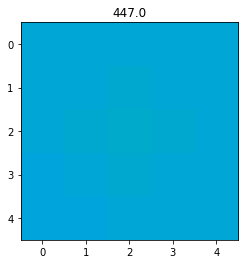

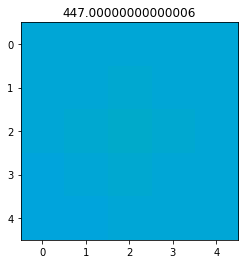

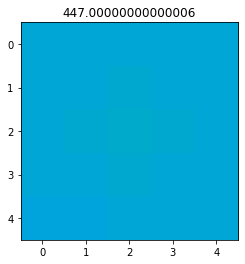

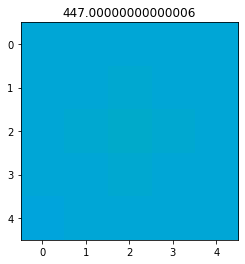

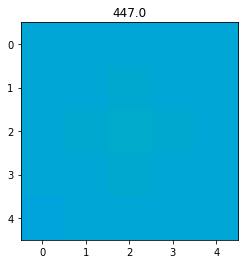

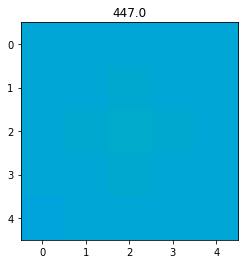

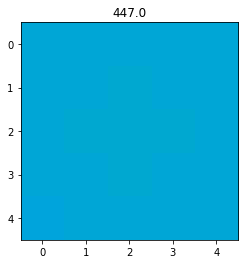

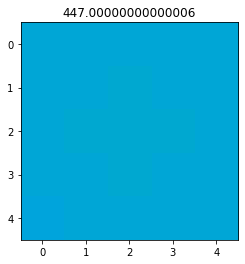

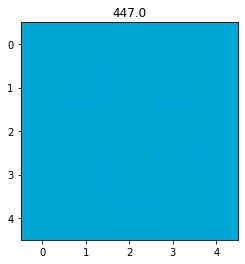

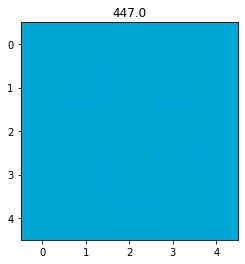

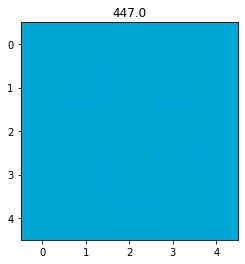

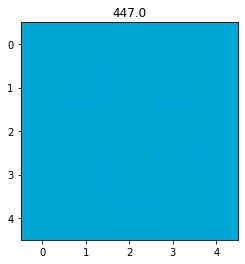

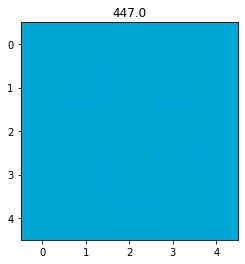

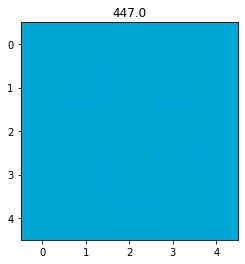

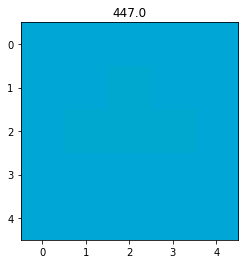

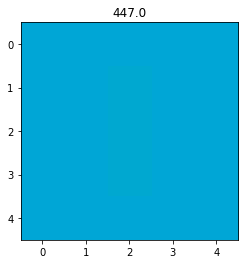

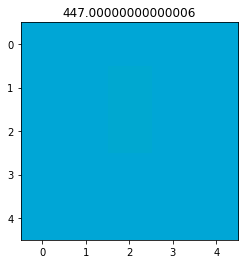

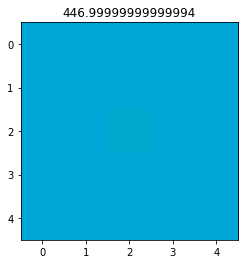

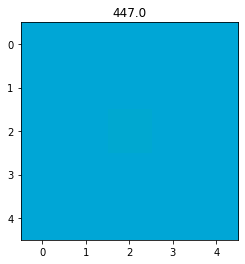

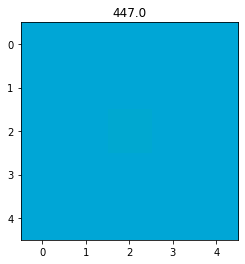

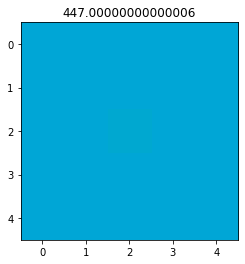

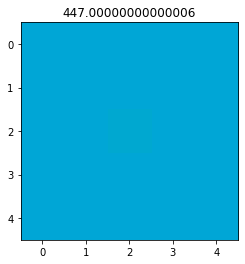

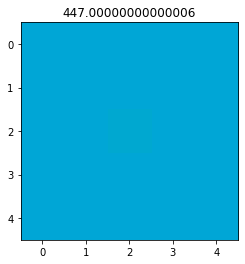

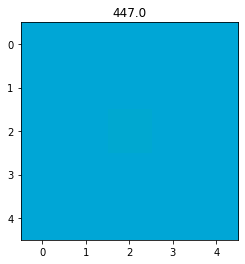

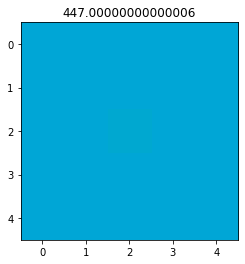

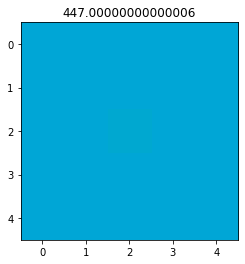

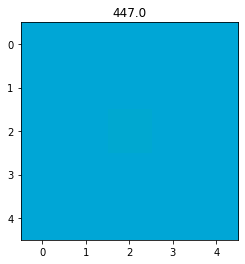

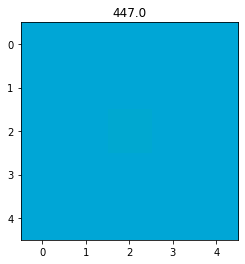

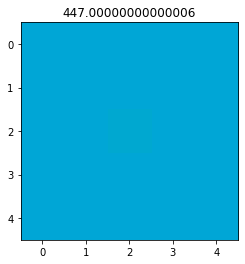

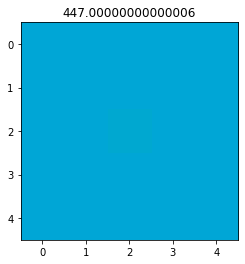

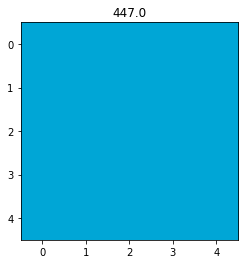

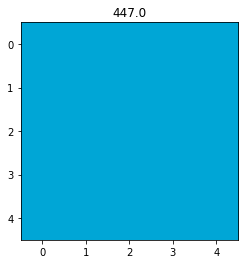

In [100]:
for i in np.arange(100):
    ww = waters[i]
    tt = terrain[i]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(tt, cmap=plt.cm.terrain, vmin=-0, vmax=100)
    ax.set_title(tt.sum())
#     plt.close(fig)